In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.decomposition import PCA
import warnings
from sklearn.model_selection import train_test_split
from PIL import Image
import random

import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

warnings.filterwarnings("ignore")

---
# Exploratory Data Analysis

It's useful to understand the structure of the dataset. The LFW dataset provides several files:

- **lfw_allnames.csv**: Contains two columns, `name` (a list of all names in the dataset) and `images` (the number of images available for each name).
- **matchpairsDevTest.csv**: A random sample of 500 image pairs featuring the same individual, with columns for the name and the two image labels.
- **matchpairsDevTrain.csv**: A random sample of 1,100 image pairs featuring the same individual, with columns for the name and the image labels.
- **mismatchpairsDevTest.csv**: A random sample of 500 image pairs featuring different individuals, with columns for both names and the two image labels.
- **mismatchpairsDevTrain.csv**: A random sample of 1,100 image pairs featuring different individuals, with columns for both names and the two image labels.
- **pairs.csv**: Contains 6,000 pairs of images, both matched and mismatched. Matched pair rows contain a name and two image files, while unmatched pair rows contain a name for each of the images. For further formatting, these rows will be split into `matched_pairs` and `unmatched_pairs` data frames.
- **people.csv**: A list of names and image counts, identical to `lfw_allnames.csv` once null values are removed. It can be omitted from further analysis.
- **peopleDevTest.csv**: Contains 1,711 individuals for testing, with columns for celebrity name and image count (no overlap with `peopleDevTrain.csv`).
- **peopleDevTrain.csv**: Contains 4,038 individuals for training, with columns for celebrity name and image count (no overlap with `peopleDevTest.csv`).

---

## Data Reshaping / Cleaning

In [3]:
raw_data_base_dir = os.path.join('..', '0_data', '0_raw', 'archive')
dataset_path = os.path.join(raw_data_base_dir,  'lfw-deepfunneled', 'lfw-deepfunneled')

lfw_allnames = pd.read_csv(f"{raw_data_base_dir}\\lfw_allnames.csv")
matchpairsDevTest = pd.read_csv(f"{raw_data_base_dir}\\matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv(f"{raw_data_base_dir}\\matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv(f"{raw_data_base_dir}\\mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv(f"{raw_data_base_dir}\\mismatchpairsDevTrain.csv")
pairs = pd.read_csv(f"{raw_data_base_dir}\\pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv(f"{raw_data_base_dir}\\people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv(f"{raw_data_base_dir}\\peopleDevTest.csv")
peopleDevTrain = pd.read_csv(f"{raw_data_base_dir}\\peopleDevTrain.csv")

In [4]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",axis=1)

---
## Image format exploration

In [5]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = dataset_path + "\\" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


---
## Further data exploration

<Axes: xlabel='name'>

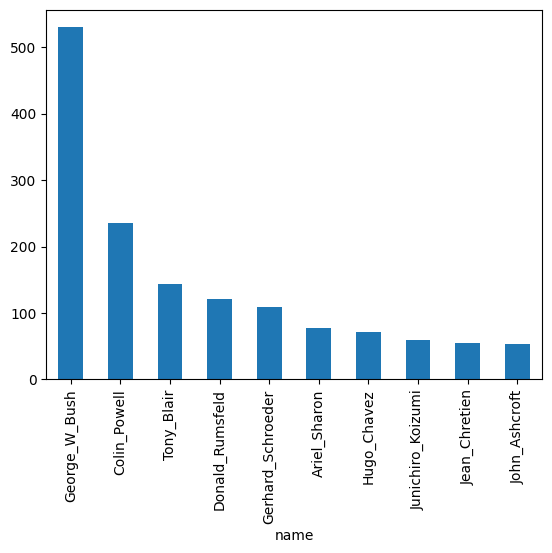

In [6]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [7]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


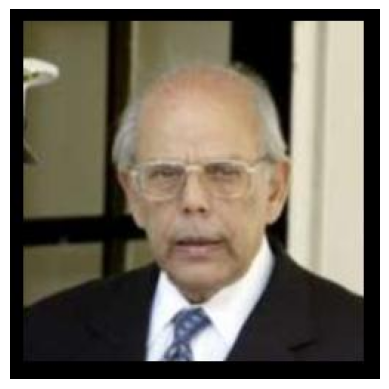

In [10]:
random_index = random.randint(0, len(image_paths) - 1)
random_image_path = dataset_path + "\\" + str(image_paths.image_path.iloc[random_index])
im = Image.open(random_image_path)
plt.imshow(im)
plt.axis('off')  # Hide axes
plt.show()

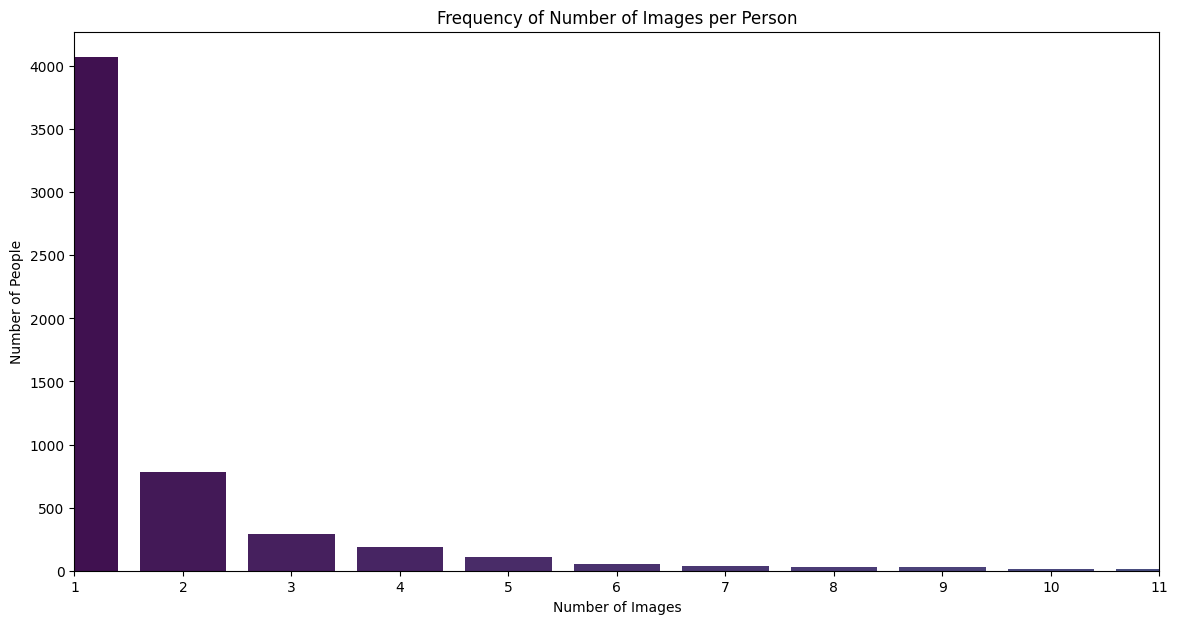

In [11]:
image_counts = lfw_allnames['images'].value_counts().sort_index()
plt.figure(figsize=(14, 7))
sns.barplot(x=image_counts.index, y=image_counts.values, palette='viridis')
plt.title('Frequency of Number of Images per Person')
plt.xlabel('Number of Images')
plt.ylabel('Number of People')
plt.xlim(0, 10)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


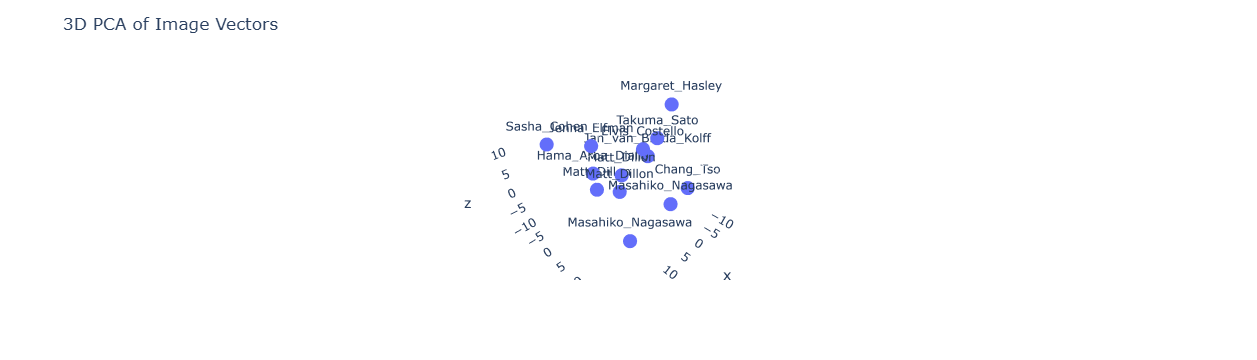

In [20]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def load_and_preprocess_image(img_path, dataset_base_path):
    full_path = os.path.join(dataset_base_path, img_path)
    img = image.load_img(full_path, target_size=(250, 250))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return img_data

def get_vector_representation(img_path):
    img_data = load_and_preprocess_image(img_path, dataset_path)
    vector = model.predict(img_data)
    return vector.flatten()

def plot_3d_vectors(vectors, labels):
    pca = PCA(n_components=3)
    reduced_vectors = pca.fit_transform(vectors)

    fig = px.scatter_3d(
        x=reduced_vectors[:, 0],
        y=reduced_vectors[:, 1],
        z=reduced_vectors[:, 2],
        text=labels
    )
    
    fig.update_traces(marker=dict(size=5), selector=dict(mode='markers'))
    fig.update_layout(
        title='3D PCA of Image Vectors',
        scene=dict(
            xaxis=dict(showbackground=False, showgrid=False),
            yaxis=dict(showbackground=False, showgrid=False),
            zaxis=dict(showbackground=False, showgrid=False)
        )
    )
    fig.show()

def visualize_random_images(image_paths_df, n=10):
    selected_people = random.sample(list(image_paths_df['name'].unique()), n)
    
    vectors = []
    labels = []

    for person in selected_people:
        person_images = image_paths_df[image_paths_df['name'] == person]
        
        for img_path in person_images['image_path'].tolist():
            vector = get_vector_representation(img_path)
            vectors.append(vector)
            labels.append(person)

    plot_3d_vectors(np.array(vectors), labels)

visualize_random_images(image_paths)